# Spades trick modeling

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

### Load hand result data

In [2]:
df = pd.read_csv('../data/hand_results.csv')
df.shape

(65036, 5)

In [60]:
df.head()

,player,cards_binary,bids,tricks_won,player_score,num_hearts,num_diamonds,num_clubs,num_spades
0,Player 1,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",3,2,-20,4,5,3,1
1,Player 2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",3,4,41,2,6,3,2
2,Player 3,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",5,6,61,3,1,6,3
3,Player 4,"[0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",1,1,10,4,1,1,7
4,Player 1,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",3,3,10,2,3,3,5


<Axes: >

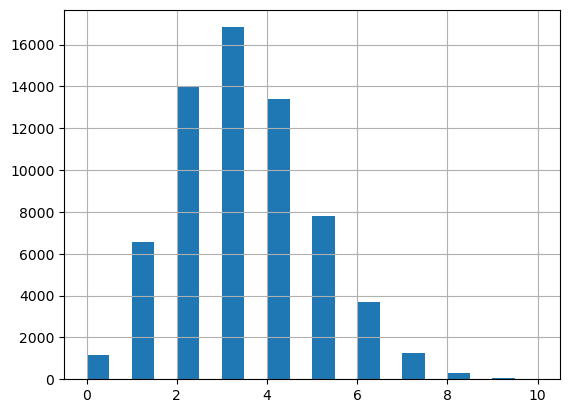

In [4]:
df['tricks_won'].hist(bins=20)

In [5]:
# check if there are any duplicate hands
df['cards_binary'].drop_duplicates().shape[0] == df['cards_binary'].shape[0]

True

### Preprocess Data

In [6]:
# Convert the cards_binary string to a numpy array of integers
def preprocess_data(row):
    return np.array([int(x) for x in row.split(',')])

In [7]:
df['cards_binary'] = df['cards_binary'].apply(preprocess_data)

In [8]:
# Add columns for suit counts
df['num_hearts'] = df['cards_binary'].apply(lambda x: sum(x[0:13]))
df['num_diamonds'] = df['cards_binary'].apply(lambda x: sum(x[13:26]))
df['num_clubs'] = df['cards_binary'].apply(lambda x: sum(x[39:52]))
df['num_spades'] = df['cards_binary'].apply(lambda x: sum(x[26:39]))

In [9]:
df.shape

(65036, 9)

In [10]:
df.head()

,player,cards_binary,bids,tricks_won,player_score,num_hearts,num_diamonds,num_clubs,num_spades
0,Player 1,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",3,2,-20,4,5,3,1
1,Player 2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",3,4,41,2,6,3,2
2,Player 3,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",5,6,61,3,1,6,3
3,Player 4,"[0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",1,1,10,4,1,1,7
4,Player 1,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",3,3,10,2,3,3,5


In [11]:
df.shape

(65036, 9)

In [12]:
X = np.stack(df['cards_binary'].values)

In [26]:
# Add additional features
additional_features = df[['num_hearts', 'num_diamonds', 'num_clubs', 'num_spades']].values
X = np.concatenate([X, additional_features], axis=1)

In [27]:
X.shape

(65036, 56)

In [28]:
y = df['tricks_won'].values

In [29]:
y.shape

(65036,)

In [30]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [31]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=123)

In [32]:
# Create datasets and dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [33]:
test_dataset.tensors[0].shape[0]

13008

In [34]:
train_dataset.tensors[0].shape[0]

52028

In [35]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Model Definition

In [78]:
class CardNet(nn.Module):
    def __init__(self):
        super(CardNet, self).__init__()
        # Define the first fully connected layer
        self.fc1 = nn.Linear(56, 128)  # 52 inputs (one for each card)
        # Sigmoid activation function
        self.sigmoid1 = nn.Sigmoid()
        # Dropout layer
        self.dropout1 = nn.Dropout(0.3)
        # Second fully connected layer
        self.fc2 = nn.Linear(128, 64)
        # Sigmoid activation function
        self.sigmoid2 = nn.Sigmoid()
        # Dropout layer
        self.dropout2 = nn.Dropout(0.2)
        # Define the output fully connected layer
        self.fc3 = nn.Linear(64, 1)  # 128 inputs, 1 output

    def forward(self, x):
        # Applying the first layer, activation, and dropout
        x = self.fc1(x)
        x = self.sigmoid1(x)
        x = self.dropout1(x)

        # Applying the second layer, activation, and dropout
        x = self.fc2(x)
        x = self.sigmoid2(x)
        x = self.dropout2(x)
        
        # Applying the output layer
        x = self.fc3(x)
        return x

### Training the Model

In [79]:
# Instantiate the model, loss function, and optimizer
model = CardNet()

criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss(beta=1.0)  # PyTorch's implementation of Huber Loss
# criterion = nn.PoissonNLLLoss()  # this went pooooorly

optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [80]:
# Training loop
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    for data, targets in train_loader:
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(data)  # Forward pass
        loss = criterion(outputs.squeeze(), targets)  # Calculate loss
        loss.backward()  # Backpropagate the error
        optimizer.step()  # Update the weights

        total_train_loss += loss.item() * data.size(0)  # Multiply loss by batch size

    # Average the loss over the entire training dataset
    train_losses.append(total_train_loss / len(train_loader.dataset))

    # Validation loss calculation
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            loss = criterion(outputs.squeeze(), targets)
            total_val_loss += loss.item() * data.size(0)  # Multiply loss by batch size

    # Average the loss over the entire validation dataset
    val_losses.append(total_val_loss / len(test_loader.dataset))

    print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

os.system(f'say Training loop is complete')

Epoch 1, Training Loss: 1.5248507655967416, Validation Loss: 0.6010326440337252
Epoch 2, Training Loss: 0.715140842947832, Validation Loss: 0.5903323271471049
Epoch 3, Training Loss: 0.686884579384841, Validation Loss: 0.5506021707773502
Epoch 4, Training Loss: 0.6520446040073657, Validation Loss: 0.5477308460487211
Epoch 5, Training Loss: 0.6442714528061585, Validation Loss: 0.5397971735082723
Epoch 6, Training Loss: 0.6330101477052262, Validation Loss: 0.5349070610155479
Epoch 7, Training Loss: 0.6222201902191635, Validation Loss: 0.5356014213658786
Epoch 8, Training Loss: 0.6144306724174334, Validation Loss: 0.5340859415639664
Epoch 9, Training Loss: 0.6088078002985777, Validation Loss: 0.5329762218476515
Epoch 10, Training Loss: 0.6034907983433984, Validation Loss: 0.5308690740833423
Epoch 11, Training Loss: 0.6018543456128094, Validation Loss: 0.5311285667900376
Epoch 12, Training Loss: 0.5939419359058093, Validation Loss: 0.5346925924331646
Epoch 13, Training Loss: 0.582418354388

0

#### Training loop with early stopping

In [ ]:
# epochs = 50
# train_losses = []
# val_losses = []

# # Early stopping logic
# best_val_loss = float('inf')
# patience = 5  # Number of epochs to wait after min has been hit
# trigger_times = 0

# for epoch in range(epochs):
#     model.train()
#     total_train_loss = 0

#     for data, targets in train_loader:
#         optimizer.zero_grad()  # Clear the gradients
#         outputs = model(data)  # Forward pass
#         loss = criterion(outputs.squeeze(), targets)  # Calculate loss
#         loss.backward()  # Backpropagate the error
#         optimizer.step()  # Update the weights

#         total_train_loss += loss.item() * data.size(0)  # Multiply loss by batch size
    
#     # Average the loss over the entire training dataset
#     train_losses.append(total_train_loss / len(train_loader.dataset))

#     # Early stopping calcs
#     model.eval()
#     total_val_loss = 0
#     with torch.no_grad():
#         for data, targets in test_loader:
#             outputs = model(data)
#             loss = criterion(outputs.squeeze(), targets)
#             total_val_loss += loss.item() * data.size(0)
    
#     average_val_loss = total_val_loss / len(test_loader.dataset)
#     if average_val_loss < best_val_loss:
#         trigger_times = 0
#         best_val_loss = average_val_loss
#         # Save the best model
#         # torch.save(model.state_dict(), 'best_model.pth')
#     else:
#         trigger_times += 1
#         if trigger_times >= patience:
#             print(f'Early stopping at epoch {epoch}')
#             break

#     print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {average_val_loss}')

#### Plot model training learning loss

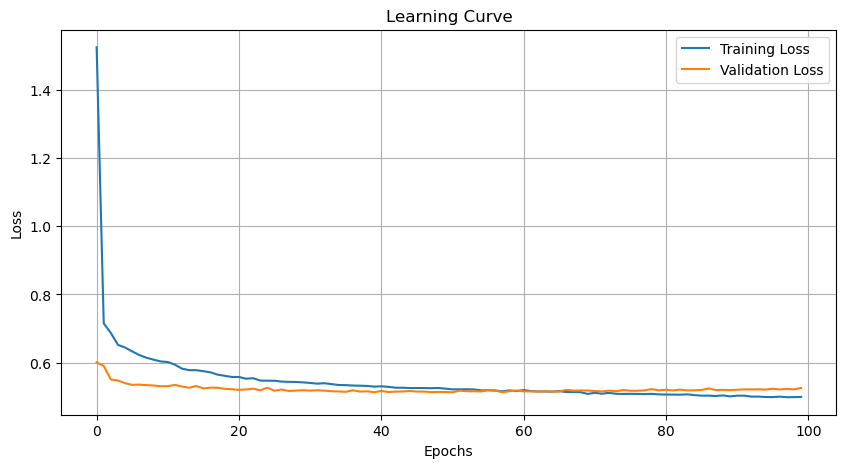

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation

In [ ]:
# model.eval()  # Set the model to evaluation mode
# with torch.no_grad():  # Turn off gradients for validation
#     total_loss = 0
#     for data, targets in test_loader:
#         outputs = model(data)
#         loss = criterion(outputs.squeeze(), targets)
#         total_loss += loss.item()
#     print(f'Test Loss: {total_loss / len(test_loader)}')

In [82]:
# Create test predictions

model.eval()  # Set the model to evaluation mode

# Store predictions and actual values
predictions = []
actuals = []

with torch.no_grad():  # Turn off gradients for prediction, saves memory and computations
    for data, targets in test_loader:
        outputs = model(data)  # Generate predictions
        predicted_tricks = outputs.squeeze().tolist()  # Convert to a list
        actual_tricks = targets.tolist()  # Actual tricks won

        predictions.extend(predicted_tricks)  # Store predictions
        actuals.extend(actual_tricks)  # Store actual values

In [83]:
mae = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error: {mse}")

preds_rounded = np.round(predictions)
acc_score = accuracy_score(actuals, preds_rounded)
print(f"Accuracy: {acc_score*100:.2f}%")

Mean Absolute Error: 0.5642053803376312
Mean Squared Error: 0.5259115040377038
Accuracy: 53.13%


### Feature importance weights

In [67]:
# Assuming model.fc1 is the first fully connected layer of the trained model
weights = model.fc1.weight.data.numpy()  # Convert the weights of the first layer to a NumPy array

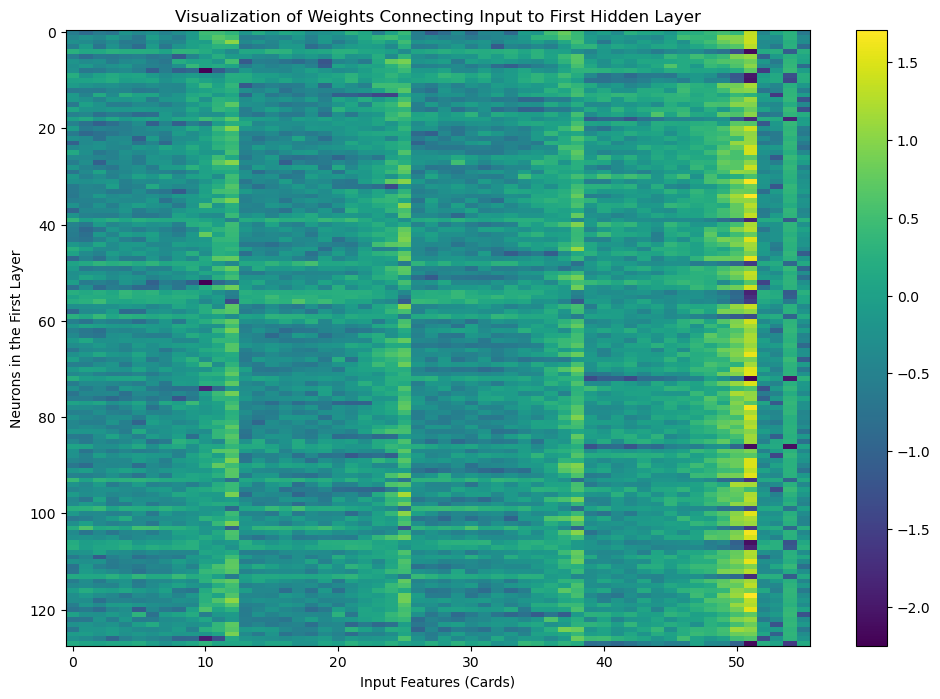

In [68]:
# Plotting the weights for each input feature
plt.figure(figsize=(12, 8))
plt.imshow(weights, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Visualization of Weights Connecting Input to First Hidden Layer')
plt.xlabel('Input Features (Cards)')
plt.ylabel('Neurons in the First Layer')
plt.show()

In [69]:
# This simplistic approach only looks at the magnitude of weights directly connected to the input features
input_importance = np.sum(np.abs(weights), axis=0)  # Sum of absolute weights across all neurons

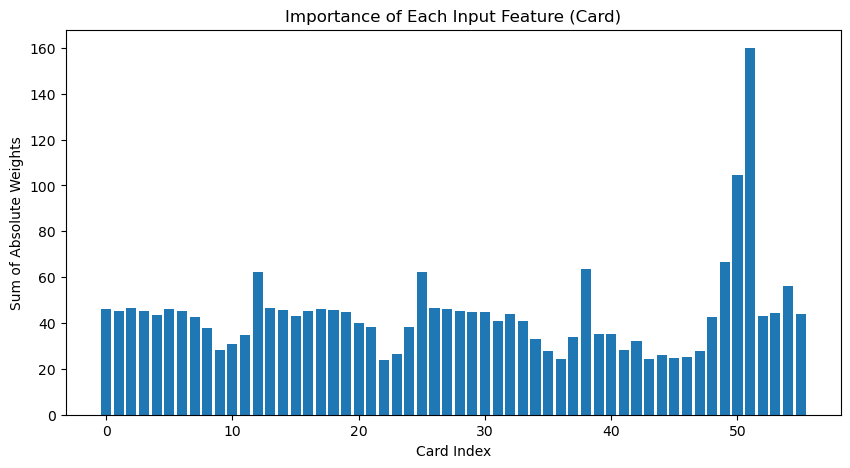

In [70]:
plt.figure(figsize=(10, 5))
plt.bar(range(56), input_importance)
plt.title('Importance of Each Input Feature (Card)')
plt.xlabel('Card Index')
plt.ylabel('Sum of Absolute Weights')
plt.show()

### sklearn RF model

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [49]:
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, 
                           max_depth=None,
                           max_features=0.9,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           random_state=123)

In [50]:
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=0.9, min_samples_leaf=2, n_estimators=200,
                      random_state=123)

In [51]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 0.9,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [52]:
# Predict on the testing set
y_pred = rf.predict(X_test)

In [53]:
# Calculate Mean Squared Error (MSE) for evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

y_pred_rounded = np.round(y_pred)
acc_score = accuracy_score(actuals, y_pred_rounded)
print(f"Accuracy: {acc_score*100:.2f}%")

Mean Squared Error: 0.5737094250137176
Accuracy: 51.91%


In [54]:
# Get feature importances from the trained model
feature_importances = rf.feature_importances_

<BarContainer object of 56 artists>

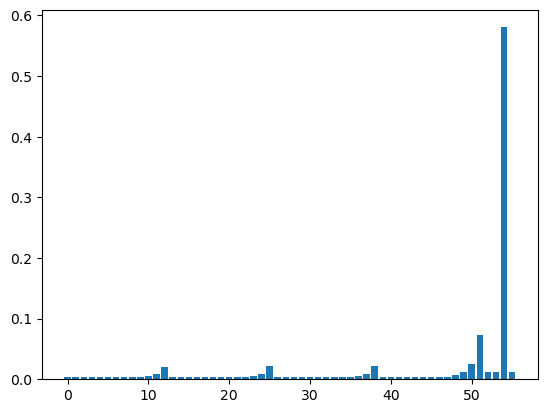

In [59]:
plt.bar(range(X.shape[1]), feature_importances)

#### Tune parameters

In [77]:
param_grid = {
    'n_estimators': [150,200],  # Num trees in the forest
    'max_depth': [None],  # Max depth of the trees
    'min_samples_leaf': [2],  # Min number of samples required to split a node
    'min_samples_split': [2],  # Min number of samples required to split a node
    'max_features': [0.9]
}

In [78]:
%%time

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

CPU times: user 27.4 s, sys: 70.9 ms, total: 27.5 s
Wall time: 53.1 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'max_depth': [None], 'max_features': [0.9],
                         'min_samples_leaf': [2], 'min_samples_split': [2],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_squared_error')

In [79]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 0.9,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [66]:
# rf.get_params()

#### Train tuned model

In [ ]:
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, 
                           max_depth=None,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           max_features=0.9,
                           random_state=123)

In [ ]:
# Train the model on training data
rf.fit(X_train, y_train)

In [ ]:
# Predict on the testing set
y_pred = rf.predict(X_test)

In [ ]:
mse = mean_squared_error(actuals, y_pred)
print(f"Mean Squared Error: {mse}")

y_pred_rounded = np.round(y_pred)
acc_score = accuracy_score(actuals, y_pred_rounded)
print(f"Accuracy: {acc_score*100:.2f}%")

### sklearn GLM model

### xgboost model